# Run inference

Steps: 
1. download model weigths
1. load model
1. List data
1. Loop over files
    - run inference
    - save result
    - visualize result

In [1]:
# Use conda_tensorflow_p36 environment in Deep learning AMI

#load packages
import boto3
import os

In [2]:
# set parameters
bucket = 'gcw-rimbunio-water-detection-dev'

prefix = 'models/development/v1_enhanced_image/'

local = '../../models/weights/'

In [3]:
# create download directory if it does not exist

try:
    # Create  Directory  MyDirectory 
    os.mkdir(local)
    #print if directory created successfully...
    print("Directory " , local ,  " Created") 
except FileExistsError:
    ##print if directory already exists...
    print("Directory " , local ,  " already exists...")

Directory  ../../models/weights/  already exists...


In [4]:
s3_resource = boto3.resource('s3')
my_bucket = s3_resource.Bucket(bucket)
objects = my_bucket.objects.filter(Prefix=prefix)

In [5]:
for obj in objects:
    
    if obj.size > 0:
    
        path, filename = os.path.split(obj.key)

        filename = local + filename

        my_bucket.download_file(obj.key, filename)

        print('done', filename)
    else: 
        print('skip object, no data')

skip object, no data
done ../../models/weights/Model_unet_1.h5


In [6]:
from segmentation_models import Unet
from segmentation_models.metrics import iou_score
from segmentation_models.losses import bce_jaccard_loss, dice_loss
from keras.optimizers import Adam
from keras.models import Input, Model
from keras.layers import Add, Conv2D, Conv2DTranspose

N = 3

base_model = Unet(backbone_name='resnet34', encoder_weights='imagenet')

inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model = Model(inp, out, name=base_model.name)
model.load_weights("../../models/weights/Model_unet_1.h5")

opt = Adam(lr=1E-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(opt, loss=bce_jaccard_loss, metrics=[iou_score,'accuracy'])

model.summary()

Using TensorFlow backend.



Segmentation Models: using `keras` framework.















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 3)     12        
_________________________________________________________________
model_2 (Model)              (None, None, None, 1)     24456154  
Total params: 24,456,166
Trainable params: 24,438,816
Non-trainable params: 17,350
_________________________________________________________________


In [7]:
# Specify the path for testing directory
test_raster_files = '../../data/nir_green_blue/*.jpg'

raster_file_base_path = '../../data/source_data'

classification_file_base_path = '../../data/nir_green_blue/classifications'


# want to 
plot_result = False

In [8]:
# create classification directory if it does not exist

try:
    # Create  Directory  MyDirectory 
    os.mkdir(classification_file_base_path)
    #print if directory created successfully...
    print("Directory " , classification_file_base_path ,  " Created") 
except FileExistsError:
    ##print if directory already exists...
    print("Directory " , classification_file_base_path ,  " already exists...")

Directory  ../../data/nir_green_blue/classifications  Created


In [12]:
from PIL import Image
import numpy as np
from skimage import transform
import glob
import ntpath
from pathlib import Path
import os
import rasterio
import matplotlib.pyplot as plt

from rasterio.crs import CRS

from tqdm.notebook import tqdm

# %matplotlib

iou_score = list()
accuracy_score = list()

def load(filename, input_shape=None):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, input_shape)
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

# Create function that reshapes numpy arrays
def reshape(index):
    index = np.reshape(index,[1,index.shape[0],index.shape[1]])
    return(index)


for file in tqdm(glob.glob(test_raster_files)):
    filename = ntpath.basename(file)
    base_path = str(Path(file).parent)
    image = load(file, (512,512,3))
    
    # Getting The Prediction
    result = model.predict(image, verbose = 0)
    result = result[0]
    # resize the result 
    result = reshape(result[:,:,0])
    
    # get the transform and save the file
    raster_file = os.path.join(raster_file_base_path, filename.replace('jpg','tif'))
    dataset = rasterio.open(raster_file)
    profile = dataset.profile
    profile.update(count=1, compress='lzw')
    
    transform_p = dataset.meta['transform']
    
    classification_filename = os.path.join(classification_file_base_path, filename.replace('jpg','tif'))
    
    # Update raster profile 1 band raster to write results    
    profile.update({'count': 1, 'crs': CRS.from_epsg(4326)})

    
    # write the file
    with rasterio.open(
            classification_filename,
            'w',
            **profile
        ) as dst:
            dst.write(result)

    if plot_result: 
        # Visualisation And Comparison
        plt.figure(figsize=(20,20))

        # The original raster file
        plt.subplot(131)
        plt.imshow(image[0,:,:,:])

        # The predicted mask file
        ax = plt.subplot(132)
        plt.imshow(result[0,:,:], cmap = 'Blues')
        plt.show()


# Test code


In [33]:
# deep learning tools
from segmentation_models import Unet
from segmentation_models.metrics import iou_score
from segmentation_models.losses import bce_jaccard_loss, dice_loss
from keras.optimizers import Adam
from keras.models import Input, Model
from keras.layers import Add, Conv2D, Conv2DTranspose

# raster manipulation packages
import rasterio
from skimage.exposure import rescale_intensity
from PIL import Image

# misc.
import glob
import os
import numpy as np

In [2]:
import overpass

In [43]:
N = 3

base_model = Unet(backbone_name='resnet34', encoder_weights='imagenet')

inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model = Model(inp, out, name=base_model.name)
model.load_weights("../models/weights/Model_unet_1.h5")

opt = Adam(lr=1E-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(opt, loss=bce_jaccard_loss, metrics=[iou_score,'accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 3)     12        
_________________________________________________________________
model_10 (Model)             (None, None, None, 1)     24456154  
Total params: 24,456,166
Trainable params: 24,438,816
Non-trainable params: 17,350
_________________________________________________________________


In [23]:
# list data 
file_path_list = glob.glob('../data/source_data_worldview_v2/*.tif')

len(file_path_list)

424

In [57]:
# loop over files

for file_path in file_path_list:

    dataset = rasterio.open(file_path)
    img_data = dataset.read()
    
#     # check dimensions and fix if necessary 
#     if img_data.shape[1] != 512 or img_data.shape[2] != 512:
#         corrected_x = x - (512 - img_data.shape[1])
#         corrected_y = y - (512 - img_data.shape[2])
#         win2 = Window(corrected_x, corrected_y, h, w)
#         img_data1 = dataset.read(window = win2)
        
#         if img_data1.shape[1] == 512 and img_data1.shape[2] == 512:
#             img_data = img_data1 
#             continue
#         else:
#             print('dimensions not achieved')
#             continue
    
    img_data = np.flipud(np.rot90(img_data.T))
    img_data = img_data[:,:,[7,2,1]]
    img_data = rescale_intensity(img_data, in_range=(0,9000), out_range=(0,2))
    img_data[img_data>1] = 1
    
    # Getting The Prediction
    img_data = np.expand_dims(img_data, axis=0)
    result = model.predict(img_data, verbose=1)
    result = result[0]
    # resize the result 
    result = reshape(result[:,:,0])
    
    result1 = np.expand_dims(result, axis=3)
    result_save = np.zeros((1,512,512,3)) + 1 
    result_save[0,:,:,2] = result1[0,:,:,0]
    result_save[0,:,:,1] = result1[0,:,:,0]
 
    # write classification to dirfrom segmentation_models import Unet
    from segmentation_models.metrics import iou_score
    from segmentation_models.losses import bce_jaccard_loss, dice_loss
    from keras.optimizers import Adam
    from keras.models import Input, Model
    from keras.layers import Add, Conv2D, Conv2DTranspose
    
    transform = dataset.window_transform(win)
      
    # Create a new cropped raster to write to
    profile = dataset.profile
    profile.update({
        'height': h,
        'width': w,
        'transform': transform,
        'count': 1})
    
    classification_filename = os.path.join('../data/nir_green_blue_v2/classifications/', filename_base)
    
    # write the file
    with rasterio.open(
            classification_filename,
            'w',
            **profile
        ) as dst:
            dst.write(result)
    
    if True:
    
        # Visualisation And Comparison
        plt.figure(figsize=(20,20))

        # The original raster file
        plt.subplot(131)
        plt.imshow(img_data[0,:,:,:])

        # The predicted mask file
        ax = plt.subplot(132)
        plt.imshow(result[0,:,:], cmap = 'Blues')
        plt.show()

InvalidArgumentError: ConcatOp : Dimensions of inputs should match: shape[0] = [1,512,30,30] vs. shape[1] = [1,256,29,29]
	 [[{{node model_10/decoder_stage0_concat/concat}}]]
	 [[{{node model_10/sigmoid/Sigmoid}}]]

In [70]:
file_path_list = glob.glob('../data/worldview/chunk/*.tif')

In [71]:
file_path_list[0]

'../data/worldview/chunk/Jakarta_022_pansharpen_True_2016-07-21_0310_103001005BA83200_131_361.tif'

In [72]:
dataset = rasterio.open(file_path_list[1])
img_data = dataset.read()
img_data = np.flipud(np.rot90(img_data.T))
img_data = img_data[:,:,[7,2,1]]
img_data = rescale_intensity(img_data, in_range=(0,9000), out_range=(0,2))
img_data[img_data>1] = 1

# Getting The Prediction


img_data = np.expand_dims(img_data, axis=0)

print(img_data.shape)
result = model.predict(img_data, verbose=1)

(1, 512, 512, 3)
1/1 [==============================] - 2s 2s/step


In [55]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 3)     12        
_________________________________________________________________
model_10 (Model)             (None, None, None, 1)     24456154  
Total params: 24,456,166
Trainable params: 24,438,816
Non-trainable params: 17,350
_________________________________________________________________


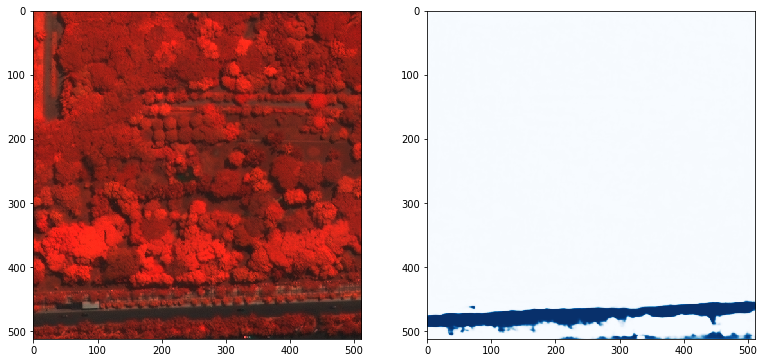

In [77]:
import matplotlib.pyplot as plt

result = result[0]
# resize the result 
result = reshape(result[:,:,0])

# Visualisation And Comparison
plt.figure(figsize=(20,20))

# The original raster file
plt.subplot(131)
plt.imshow(img_data[0,:,:,:])

# The predicted mask file
ax = plt.subplot(132)
plt.imshow(result[0,:,:], cmap = 'Blues')
plt.show()